In [1]:
%%capture
%cd .. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path
data_dir = Path('data')

In [3]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool

## $\pi$ estimation exemple

Given a circle region $C$ of radius $R$, centred on origin, and arbitrary values $x, y \in [0, R]$,
$$
R^2 p((x, y) \in C) = \frac{\pi R^2}{4} \longrightarrow \pi = 4p((x, y) \in C),
$$
cosiderating
$$
p((x, y) \in C) = \lim_{N \to \infty} \frac{\sum_{i}^N g(\sqrt{x_i^2 + y_i^2})}{N},
$$
where
$$
g(r) = \left\{
    \begin{array}{rl}
        1, & r \le 1\\
        0, & r > 1
    \end{array}
\right..
$$

In [4]:
from random import random
from math import sqrt

def timeit(function, *args, **kwargs):
    t0 = time.time()
    y = function(*args, **kwargs)
    tf = time.time()
    return tf - t0, y

def exception_filter(function):
    def wrapper(*args, **kwargs):
        y = None
        try: y = function(*args, **kwargs)
        except Exception as error: print(error)
        return y
    return wrapper

def N_in(N):
    return sum((sqrt(random()**2 + random()**2) <= 1 for _ in range(N)))

@exception_filter
def approx_pi(N):
    return 4*N_in(N)/N

@exception_filter
def approx_pi_concurrent(N: int, n_workers: int) -> float:
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        output = executor.map(N_in, [int(N/n_workers)]*n_workers)
    return 4*np.sum(np.fromiter(output, int))/N

@exception_filter
def approx_pi_multiprocess(N: int, n_workers: int) -> float:
    with Pool(n_workers) as pool:
        output = pool.map(N_in, [int(N/n_workers)]*n_workers)
    return 4*np.sum(np.fromiter(output, int))/N

In [7]:
delay, pi = timeit(approx_pi, int(1e8))
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 22.62261939048767 s
pi: 3.14167224


In [6]:
delay, pi = timeit(approx_pi_concurrent, int(1e7), 4)
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 8.325867652893066 s
pi: 3.1413256


In [8]:
delay, pi = timeit(approx_pi_multiprocess, int(1e7), 4)
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 0.7241218090057373 s
pi: 3.1422152


In [ ]:
%%time

w = 10
columns=('method', 'workers', 'N', 'delay', 'pi')
df = []
for N in np.linspace(1e5, 1e11, 15).astype(int):
    for _ in range(3):
        for workers in np.arange(1, w + 1):
            if workers == 1:
                if N > 1e8: continue
                df.append(('sequential', 1, N, *timeit(approx_pi, N)))
            df.append(('threading', workers, N, *timeit(approx_pi_concurrent, N, workers)))
            df.append(('multiprocessing', workers, N, *timeit(approx_pi_multiprocess, N, workers)))
df = pd.DataFrame(df, columns=columns)
df['delay_per_point'] = df.delay/df.N
df.to_csv(data_dir/'approx_pi.csv')
df.head()

Unable to allocate 106. GiB for an array with shape (7142950000, 2) and data type float64
Unable to allocate 106. GiB for an array with shape (7142950000, 2) and data type float64
Unable to allocate 106. GiB for an array with shape (7142950000, 2) and data type float64


In [48]:
df = pd.read_csv(data_dir/'approx_pi.csv', index_col='Unnamed: 0')
df.head()

,method,workers,N,delay,pi,delay_per_point
0,threading,1,100000,0.038278,3.060310,3.827834e-07
1,multiprocessing,1,100000,0.054324,3.065505,5.432367e-07
2,sequential,1,100000,0.039633,3.060571,3.963256e-07
3,threading,2,100000,0.072698,3.054153,7.269812e-07
4,multiprocessing,2,100000,0.042503,3.067893,4.250312e-07


In [49]:
seq = df.method == 'sequential'
thr = df.method == 'threading'
mul = df.method == 'multiprocessing'

In [50]:
at_N_max = df[mul & (df.N == df.N.max())]
at_N_max.delay.max(), at_N_max.delay.min(), 100*(at_N_max.delay.max() - at_N_max.delay.min())/at_N_max.delay.max()

(19.65369725227356, 1.3428301811218262, 93.16754418323765)

In [51]:
at_N_max = df[thr & (df.N == df.N.max())]
at_N_max.delay.max(), at_N_max.delay.min(), 100*(at_N_max.delay.max() - at_N_max.delay.min())/at_N_max.delay.max()

(74.80382704734802, 19.556450843811035, 73.85634984767219)

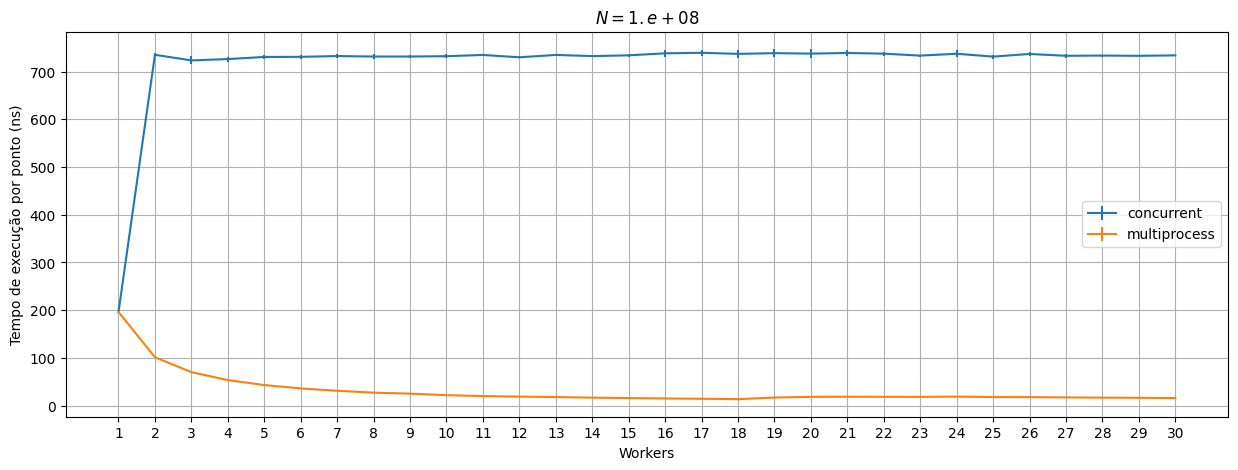

In [6]:
t = df.workers.unique()
loc = (df.N == df.N.max())
scale = 1e9
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
# plt.semilogy()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.max(), 0)))
plt.show()

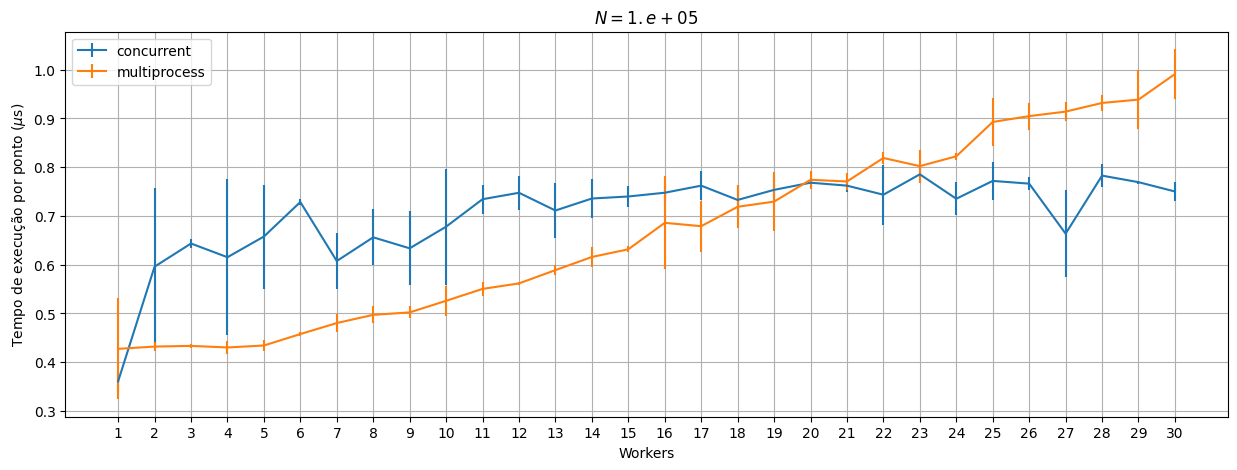

In [19]:
t = df.workers.unique()
loc = (df.N == df.N.min())
scale = 1e6
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
# plt.semilogy()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto ($\mu$s)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.min(), 0)))
plt.show()

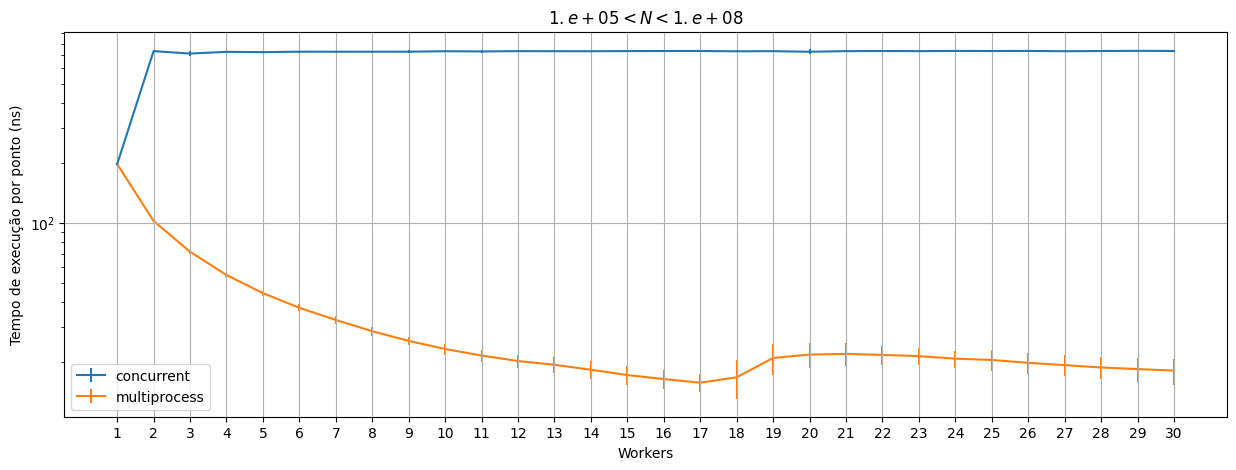

In [13]:
thr_vals = []
mul_vals = []
for N in df.N.unique()[1:-1]:
    loc = (df.N == N)
    thr_vals.append(np.stack(df[thr & loc].groupby('workers').agg(list)['delay_per_point'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('workers').agg(list)['delay_per_point'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)

scale = 1e9
t = df.workers.unique()
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_vals.mean(axis=1)*scale, thr_vals.std(axis=1)*scale, label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1)*scale, mul_vals.std(axis=1)*scale, label='multiprocess', zorder=0)
plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'${} < N < {}$'.format(np.format_float_scientific(df.N.min(), 0), np.format_float_scientific(df.N.max(), 0)))
plt.show()

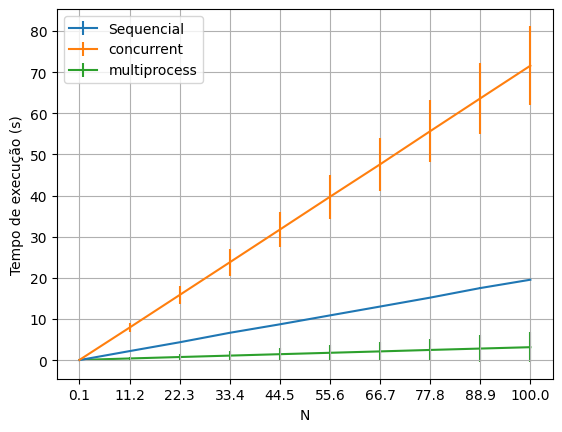

In [15]:
thr_vals = []
mul_vals = []
for workers in df.workers.unique():
    loc = (df.workers == workers)
    thr_vals.append(np.stack(df[thr & loc].groupby('N').agg(list)['delay'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('N').agg(list)['delay'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)
seq_vals = np.stack(df[seq].groupby('N').agg(list)['delay'].values)

scale = 1e-6
t = df.N.unique()*scale
plt.errorbar(t, seq_vals.mean(axis=1), seq_vals.std(axis=1), label='Sequencial')
plt.errorbar(t, thr_vals.mean(axis=1), thr_vals.std(axis=1), label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1), mul_vals.std(axis=1), label='multiprocess', zorder=0)
# plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel(r'Tempo de execução (s)')
plt.show()

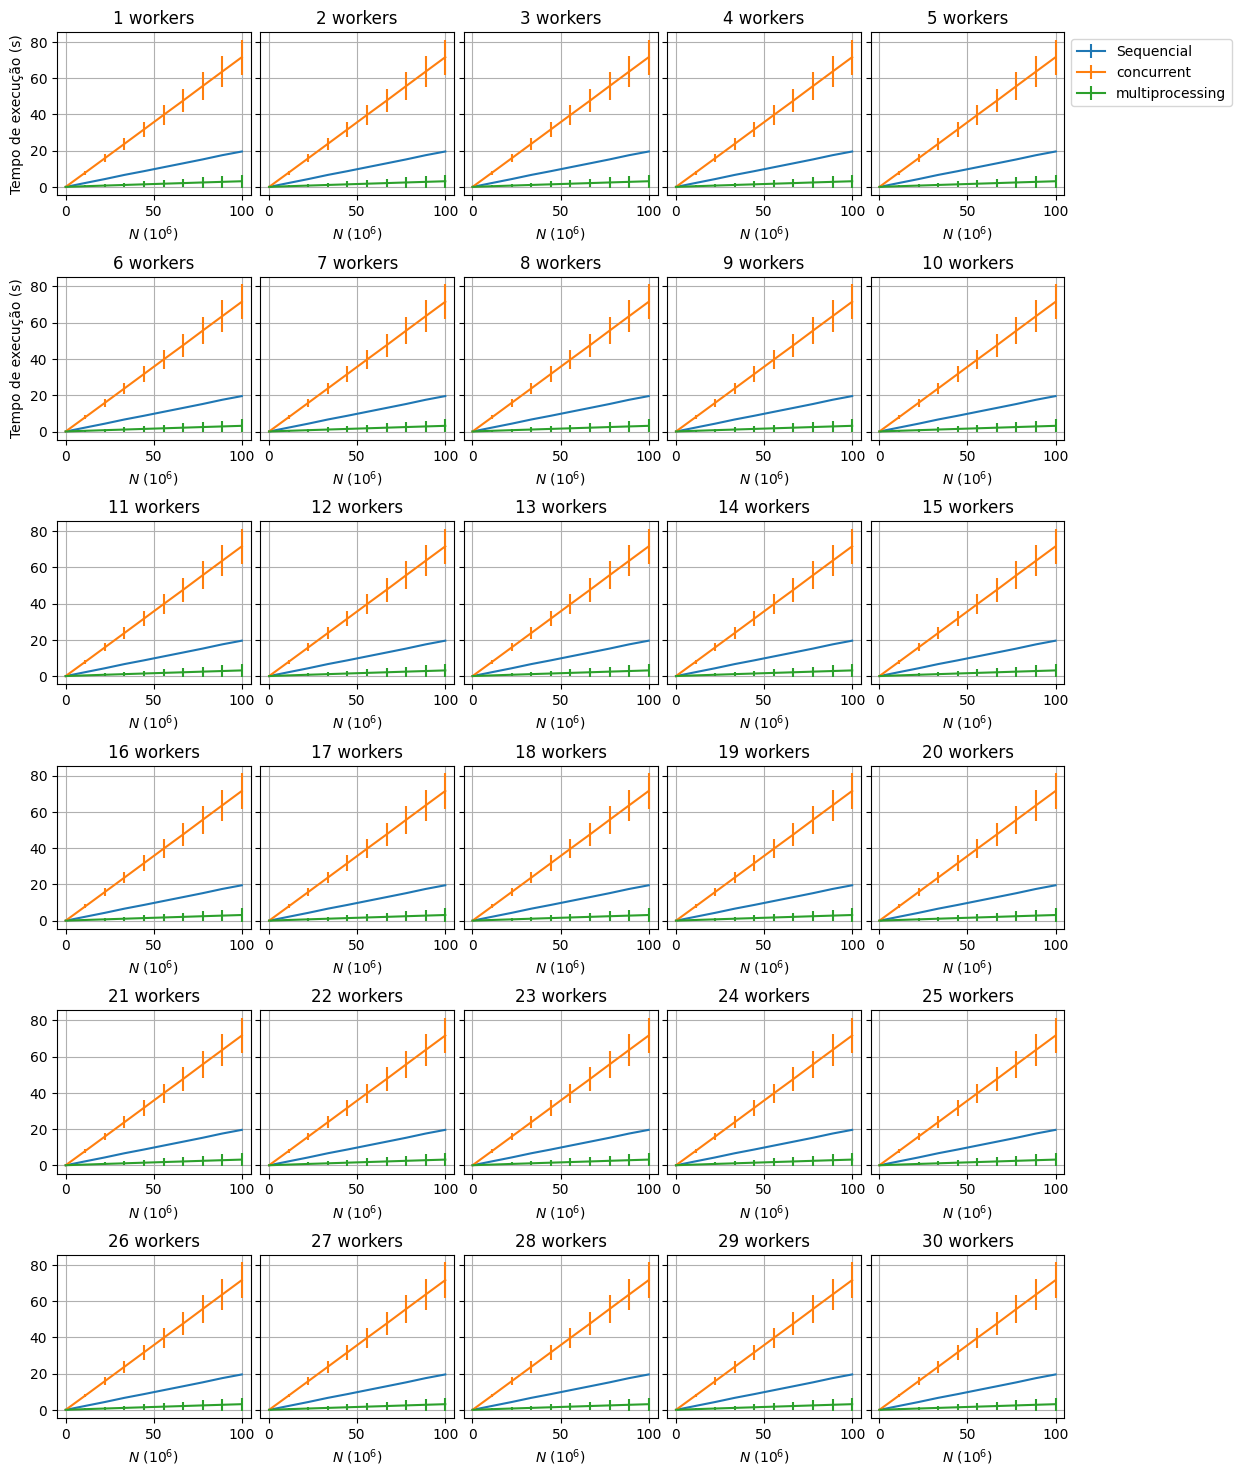

In [17]:
fig, axs = plt.subplots(6, 5, figsize=(13, 18), sharey=True)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5)

scale = 1e-6
for ax, w in zip(np.ravel(axs), df.workers.unique()):
    loc = df.workers == w
    seq_vals = df[seq].groupby('N')
    ax.errorbar(df.N.unique()*scale, seq_vals.mean(numeric_only=True).delay, seq_vals.std(numeric_only=True).delay, label='Sequencial')
    thr_vals = df[thr].groupby('N')
    ax.errorbar(df.N.unique()*scale, thr_vals.mean(numeric_only=True).delay, thr_vals.std(numeric_only=True).delay, label='concurrent')
    mul_vals = df[mul].groupby('N')
    ax.errorbar(df.N.unique()*scale, mul_vals.mean(numeric_only=True).delay, mul_vals.std(numeric_only=True).delay, label='multiprocessing')
    ax.grid()
    if ax == axs[0][4]: ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(f'{w} workers')
    ax.set_xlabel(r'$N$ ($10^6$)')

axs[0][0].set_ylabel('Tempo de execução (s)')
axs[1][0].set_ylabel('Tempo de execução (s)')

plt.show()
# plt.gca().set_aspect('equal')

In [44]:
df = pd.read_csv(data_dir/'approx_pi_numpy.csv', index_col='Unnamed: 0')
df.head()

,method,workers,N,delay,pi,delay_per_point
0,threading,1,100000,0.061430,3.14412,6.142998e-07
1,multiprocessing,1,100000,0.019348,3.14212,1.934814e-07
2,sequential,1,100000,0.008371,3.14212,8.371115e-08
3,threading,2,100000,0.009289,3.14220,9.288788e-08
4,multiprocessing,2,100000,0.024101,3.13744,2.410054e-07


In [45]:
seq = df.method == 'sequential'
thr = df.method == 'threading'
mul = df.method == 'multiprocessing'

In [46]:
at_N_max = df[mul & (df.N == df.N.max())]
at_N_max.delay.max(), at_N_max.delay.min(), 100*(at_N_max.delay.max() - at_N_max.delay.min())/at_N_max.delay.max()

(2.8204050064086914, 0.6855854988098145, 75.69194859419174)

In [47]:
at_N_max = df[thr & (df.N == df.N.max())]
at_N_max.delay.max(), at_N_max.delay.min(), 100*(at_N_max.delay.max() - at_N_max.delay.min())/at_N_max.delay.max()

(2.7689123153686523, 1.422133445739746, 48.63927478503762)

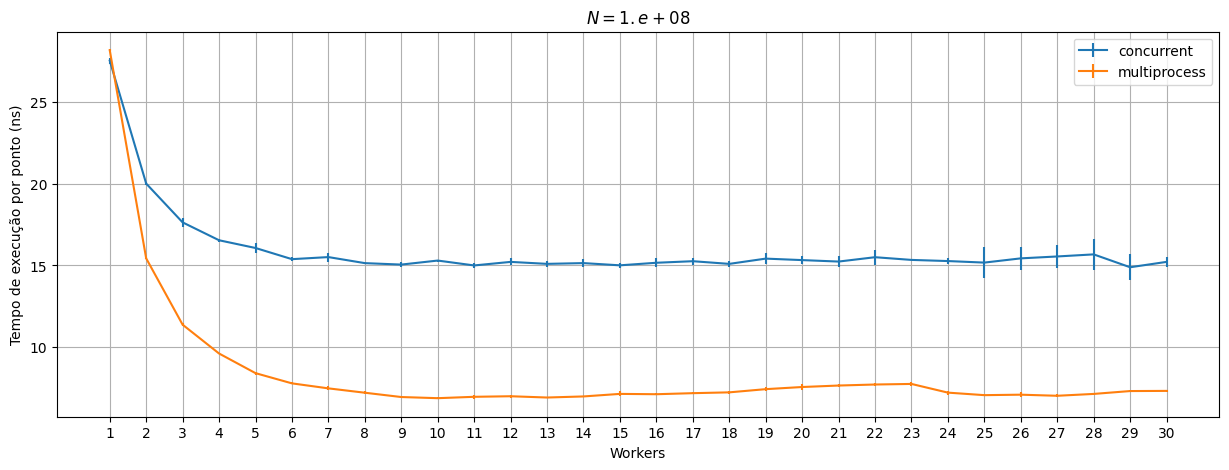

In [9]:
t = df.workers.unique()
loc = (df.N == df.N.max())
scale = 1e9
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
# plt.semilogy()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.max(), 0)))
plt.show()

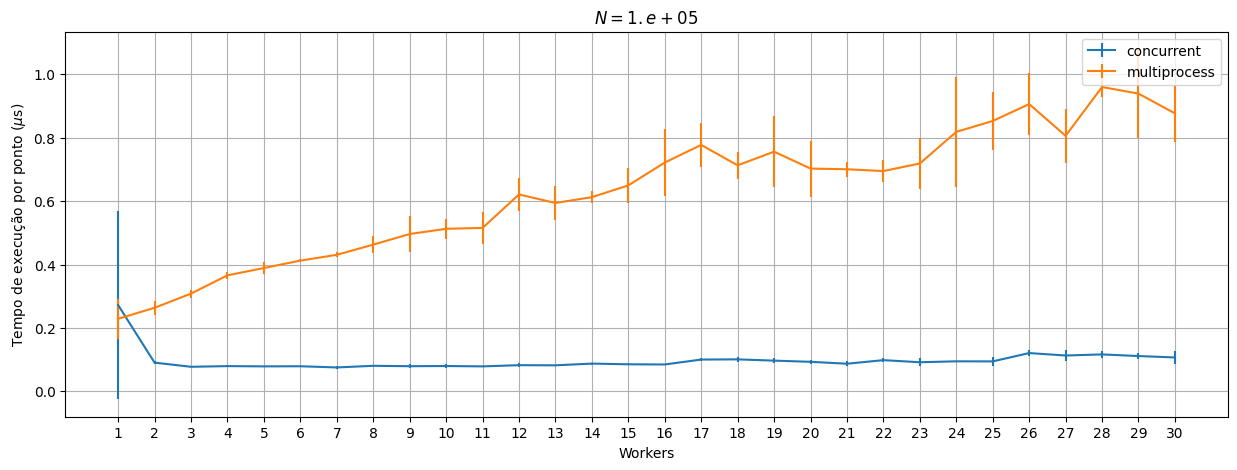

In [10]:
t = df.workers.unique()
loc = (df.N == df.N.min())
scale = 1e6
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
# plt.semilogy()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto ($\mu$s)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.min(), 0)))
plt.show()

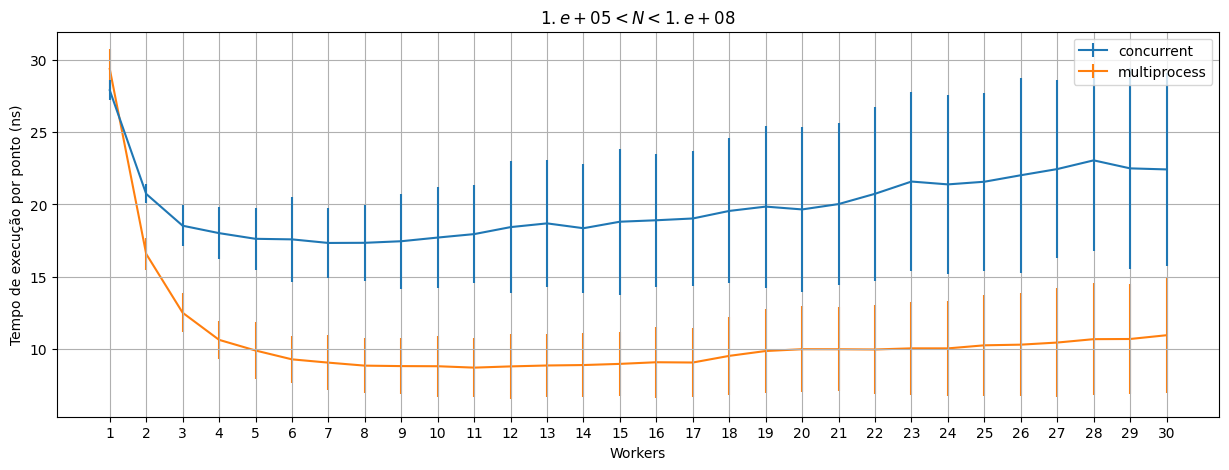

In [13]:
thr_vals = []
mul_vals = []
for N in df.N.unique()[1:-1]:
    loc = (df.N == N)
    thr_vals.append(np.stack(df[thr & loc].groupby('workers').agg(list)['delay_per_point'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('workers').agg(list)['delay_per_point'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)

scale = 1e9
t = df.workers.unique()
plt.figure(figsize=(15, 5))
plt.errorbar(t, thr_vals.mean(axis=1)*scale, thr_vals.std(axis=1)*scale, label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1)*scale, mul_vals.std(axis=1)*scale, label='multiprocess', zorder=0)
# plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'${} < N < {}$'.format(np.format_float_scientific(df.N.min(), 0), np.format_float_scientific(df.N.max(), 0)))
plt.show()

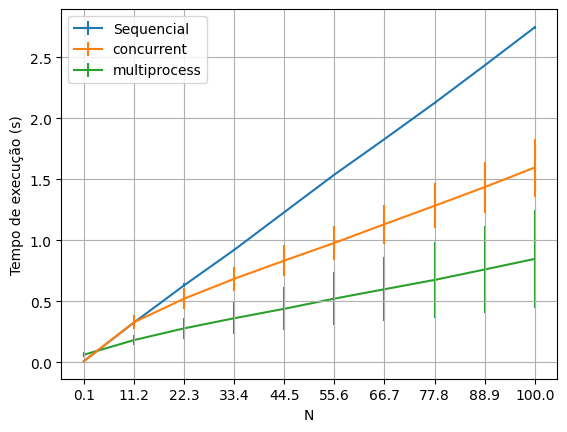

In [12]:
thr_vals = []
mul_vals = []
for workers in df.workers.unique():
    loc = (df.workers == workers)
    thr_vals.append(np.stack(df[thr & loc].groupby('N').agg(list)['delay'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('N').agg(list)['delay'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)
seq_vals = np.stack(df[seq].groupby('N').agg(list)['delay'].values)

scale = 1e-6
t = df.N.unique()*scale
plt.errorbar(t, seq_vals.mean(axis=1), seq_vals.std(axis=1), label='Sequencial')
plt.errorbar(t, thr_vals.mean(axis=1), thr_vals.std(axis=1), label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1), mul_vals.std(axis=1), label='multiprocess', zorder=0)
# plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel(r'Tempo de execução (s)')
plt.show()

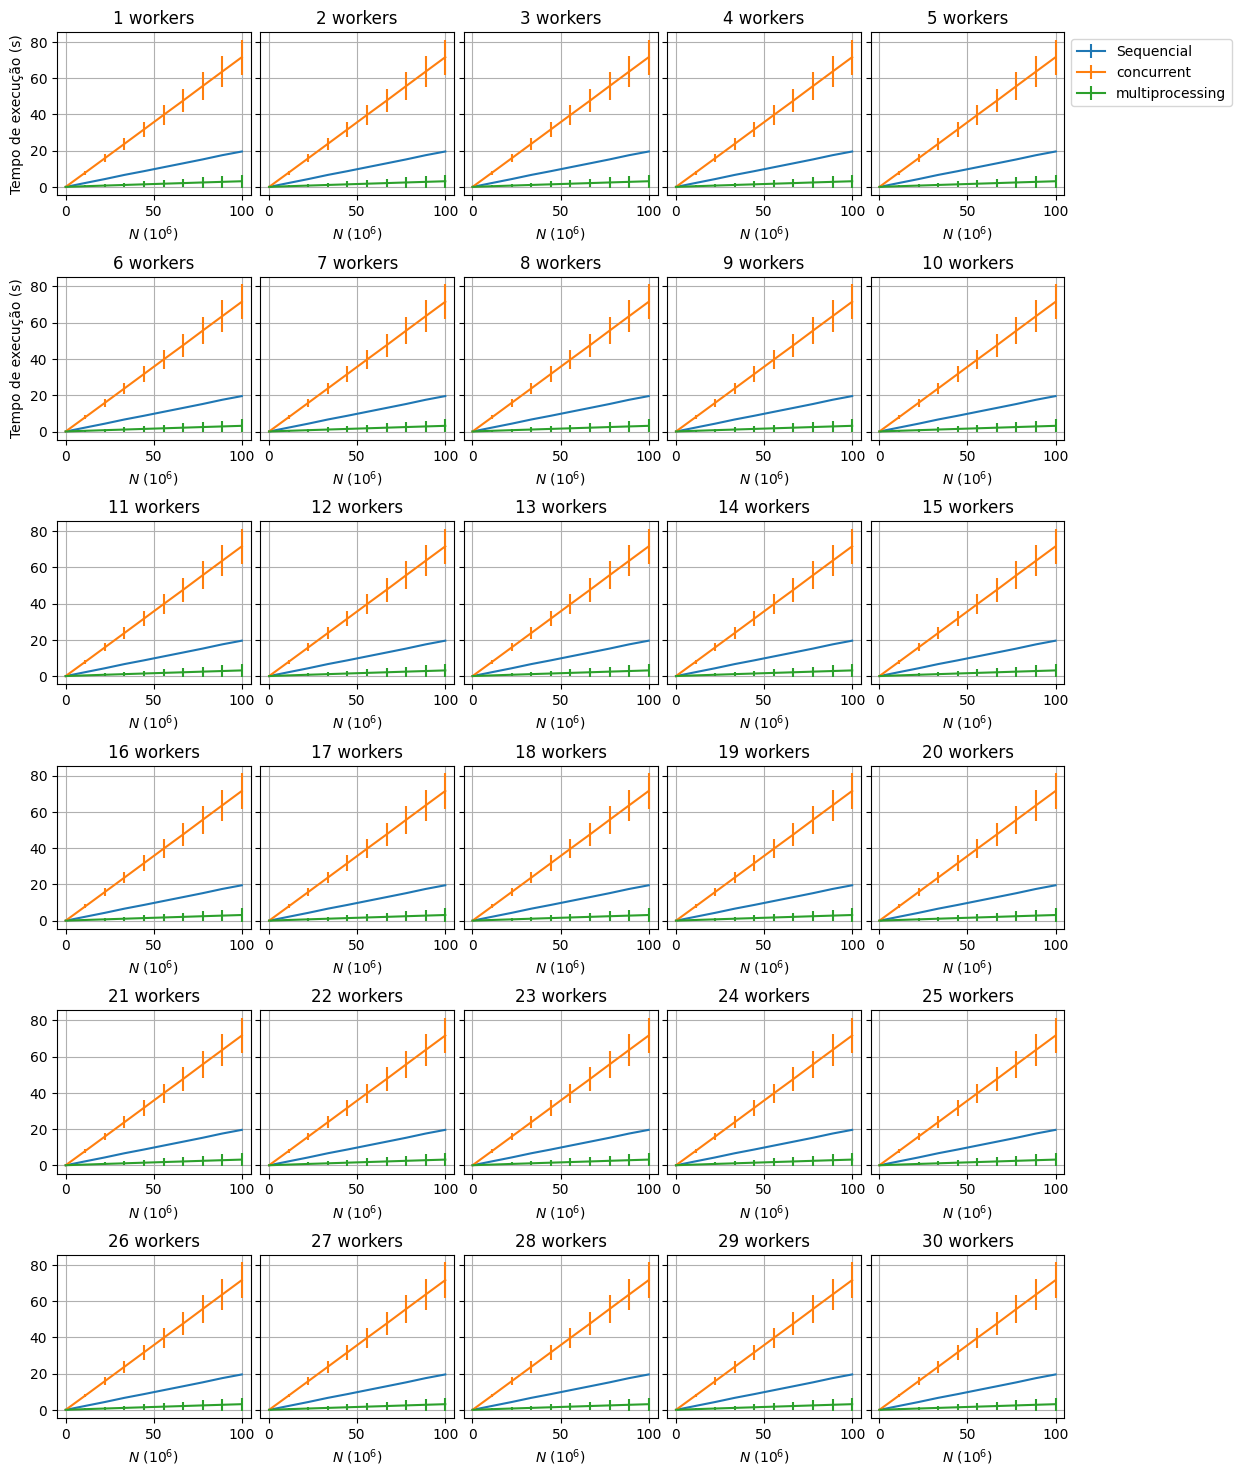

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(13, 18), sharey=True)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5)

scale = 1e-6
for ax, w in zip(np.ravel(axs), df.workers.unique()):
    loc = df.workers == w
    seq_vals = df[seq].groupby('N')
    ax.errorbar(df.N.unique()*scale, seq_vals.mean(numeric_only=True).delay, seq_vals.std(numeric_only=True).delay, label='Sequencial')
    thr_vals = df[thr].groupby('N')
    ax.errorbar(df.N.unique()*scale, thr_vals.mean(numeric_only=True).delay, thr_vals.std(numeric_only=True).delay, label='concurrent')
    mul_vals = df[mul].groupby('N')
    ax.errorbar(df.N.unique()*scale, mul_vals.mean(numeric_only=True).delay, mul_vals.std(numeric_only=True).delay, label='multiprocessing')
    ax.grid()
    if ax == axs[0][4]: ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(f'{w} workers')
    ax.set_xlabel(r'$N$ ($10^6$)')

axs[0][0].set_ylabel('Tempo de execução (s)')
axs[1][0].set_ylabel('Tempo de execução (s)')

plt.show()
# plt.gca().set_aspect('equal')